<h3 style="text-align: center">Modelo ML utilizando  Dataset de alquiler de bicicletas en Washington</h3>
<h4>Hecho Por:

      -  Santiago Fernández Seoane

      -  Alejandro Regueiro Ruiz

      -  Pablo López Martínez

      -  Adriana Rodríguez Rey
</h4>



<h3 style="text-align: center">Regresión lineal utilizando  Dataset de alquiler de bicicletas en Washington</h3>


<p>Importación de las librerías:</p>

- Las primeras librerías son las fundamentales para el cálculo, visualización, manipulación y análisis de datos.
- La librería *sklearn* es clave para el aprendizaje automático. Incluimos submódulos que nos permiten usar:
    * El módulo clásico de regresión lineal. 
    * Métricas de evaluación.
    * División de datos en conjunto de entrenamiento y prueba.
    * Regresión lineal con regularización.
- *seaborn* es utilizada para la visualización con gráficos.

In [1403]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from packaging import version
import kagglehub
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, r2_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression, ElasticNet
import seaborn as sns

### Si tenemos el dataset descargado lo ejecutaremos con la primera celda, de lo contrario usamos el import de kaggle para descargarlo directamente

In [1404]:
#path = 'dataset/1'

In [1405]:
# Descargamos el dataset
path = kagglehub.dataset_download("lakshmi25npathi/bike-sharing-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\santiago.fernandezse\.cache\kagglehub\datasets\lakshmi25npathi\bike-sharing-dataset\versions\1


### Leemos el dataset

In [1406]:
dfBikingRental = pd.read_csv(f'{path}/day.csv')
dfBikingRental

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


### Miramos los tipos de datos y la cantidad de datos con las que trabajaremos

In [1407]:
dfBikingRental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


### Excluimos los *outliers* menores 0.05 y mayores 0.95, y los eliminamos junto con la columna *dteday*, ya que contiene datos que no aportan valor.

In [1408]:
qM = dfBikingRental["cnt"].quantile(0.95)
qm = dfBikingRental["cnt"].quantile(0.05)
dfBikingRental = dfBikingRental[(dfBikingRental["cnt"] > qm) & (dfBikingRental["cnt"] < qM)]
dfBikingRental = dfBikingRental.drop("dteday",axis=1)

Generamos un **mapa de calor (heatmap)** que muestra la correlación entre las variables.

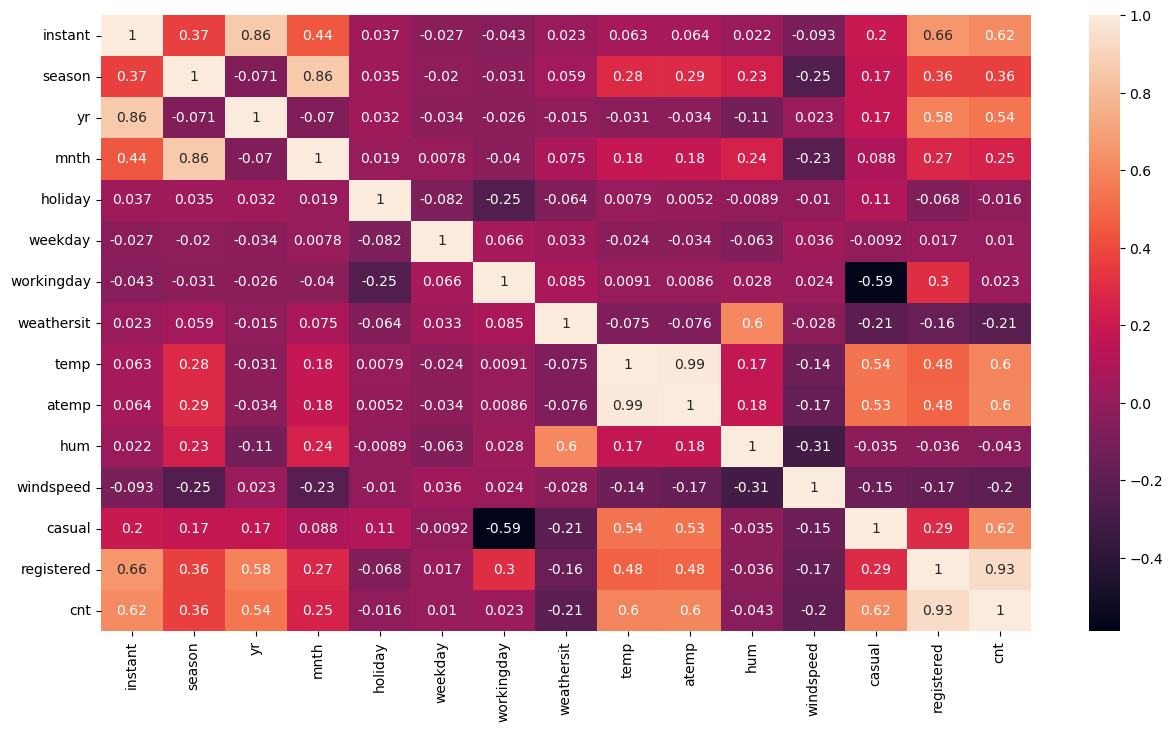

In [1409]:
plt.figure(figsize=(15, 8))
sns.heatmap(dfBikingRental.corr(),annot=True)
plt.show()

Definimos *x* (características).  
Definimos *y* (etiquetas).  
  
Dividimos los datos de entrenamiento (85%) y prueba (15%).

In [1410]:
X = dfBikingRental[["mnth", "holiday", "yr","weekday", "workingday", "weathersit", "atemp", "hum", "windspeed"]].values
y = dfBikingRental["cnt"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

Creamos y entrenamos el modelo de regresión lineal usando los datos de entrenamiento *x_train* e *y_train*.
Predecimos el valor el *cnt*(cantidad total de usuarios) basandonos en el conjunto de prueba *x_test* y lo guardamos.

Evaluamos el rendiemiento del modelo calculando el Error Cuadrático:
* **Error Cuadrático Medio (MSE)**. Cuánto se desvían las predicciones de los valores reales.
* **Raíz del Error Cuadrático Medio (RMSE)**.
* **Coeficiente de determinación $R^2$**. Porcentaje de variabilidad de *y* explicada por *x*.


Nos fijamos en el RMSE, el cual nos dará la aproximación más exacta de el error medio.

In [1411]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print ("Error Cuadrático Medio:", mse)
print ("Raíz del Error Cuadrático Medio:", rmse)
print ("Coeficiente de determinación R2:", r2)

print(f'La prediccion  tiene un fallo  Cuadrático de : {rmse:.2f}  ')

Error Cuadrático Medio: 576500.1171132601
Raíz del Error Cuadrático Medio: 759.2760480307936
Coeficiente de determinación R2: 0.7924699408850093
La prediccion  tiene un fallo  Cuadrático de : 759.28  


Hemos Probado utilizando SGD con todos las regularizaciones posibles, pero ninguna ha mejorado la raiz del error cuadrático 

In [1412]:
regressor = SGDRegressor(loss="squared_error", penalty="elasticnet", random_state=42 ,max_iter=500)
regressor.fit(X_train, y_train)

y_pred_prueba = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred_prueba)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_prueba)
print ("Error Cuadrático Medio:", mse)
print ("Raíz del Error Cuadrático Medio:", rmse)
print ("Coeficiente de determinación R2:", r2)

print(f'La prediccion  tiene un fallo  Cuadrático de : {rmse:.2f}  ')

Error Cuadrático Medio: 833762.7962816434
Raíz del Error Cuadrático Medio: 913.1061254211602
Coeficiente de determinación R2: 0.6998598313099467
La prediccion  tiene un fallo  Cuadrático de : 913.11  


c:\Users\santiago.fernandezse\AppData\Local\miniconda3\envs\pia\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Creamos un DataFrame para visualizar las variables de prueba y su comparación con la de precicción o valor real.

In [1413]:
df = pd.DataFrame({
    'mnth': X_test[:, 0].flatten(),
    'holiday': X_test[:, 1].flatten(),
    'yr': X_test[:, 2].flatten(),
    'weekday': X_test[:, 3].flatten(),
    'workingday': X_test[:, 4].flatten(),
    'weathersit': X_test[:, 5].flatten(),
    'temp': X_test[:, 6].flatten(),
    'hum': X_test[:, 7].flatten(),
    'windspeed': X_test[:, 8].flatten(),
    'Real': y_test.flatten(),
    'Prediccion': y_pred.flatten()
})
df

,mnth,holiday,yr,weekday,workingday,weathersit,temp,hum,windspeed,Real,Prediccion
0,11.0,0.0,1.0,4.0,1.0,1.0,0.298422,0.555652,0.115522,5323,5963.552720
1,10.0,0.0,0.0,0.0,0.0,1.0,0.422333,0.741250,0.099513,4381,4038.982668
2,11.0,0.0,0.0,6.0,0.0,1.0,0.357942,0.552917,0.212062,4067,4032.622276
3,3.0,0.0,0.0,0.0,0.0,2.0,0.250339,0.493913,0.184300,1693,1550.649841
4,11.0,1.0,0.0,4.0,0.0,1.0,0.372471,0.549167,0.167304,1495,4018.290092
...,...,...,...,...,...,...,...,...,...,...,...
94,12.0,0.0,0.0,3.0,1.0,2.0,0.338362,0.663750,0.060958,3740,3576.991942
95,7.0,0.0,0.0,2.0,1.0,1.0,0.747479,0.650417,0.130600,4541,5033.581171
96,10.0,0.0,1.0,2.0,1.0,1.0,0.460846,0.558333,0.182221,7534,6308.257371
97,4.0,0.0,0.0,3.0,1.0,1.0,0.564392,0.614167,0.241925,3944,4000.445513


Generamos una gráfica para visualizar los valores reales y las predicciones de nuestro modelo y percibir el margen de error.

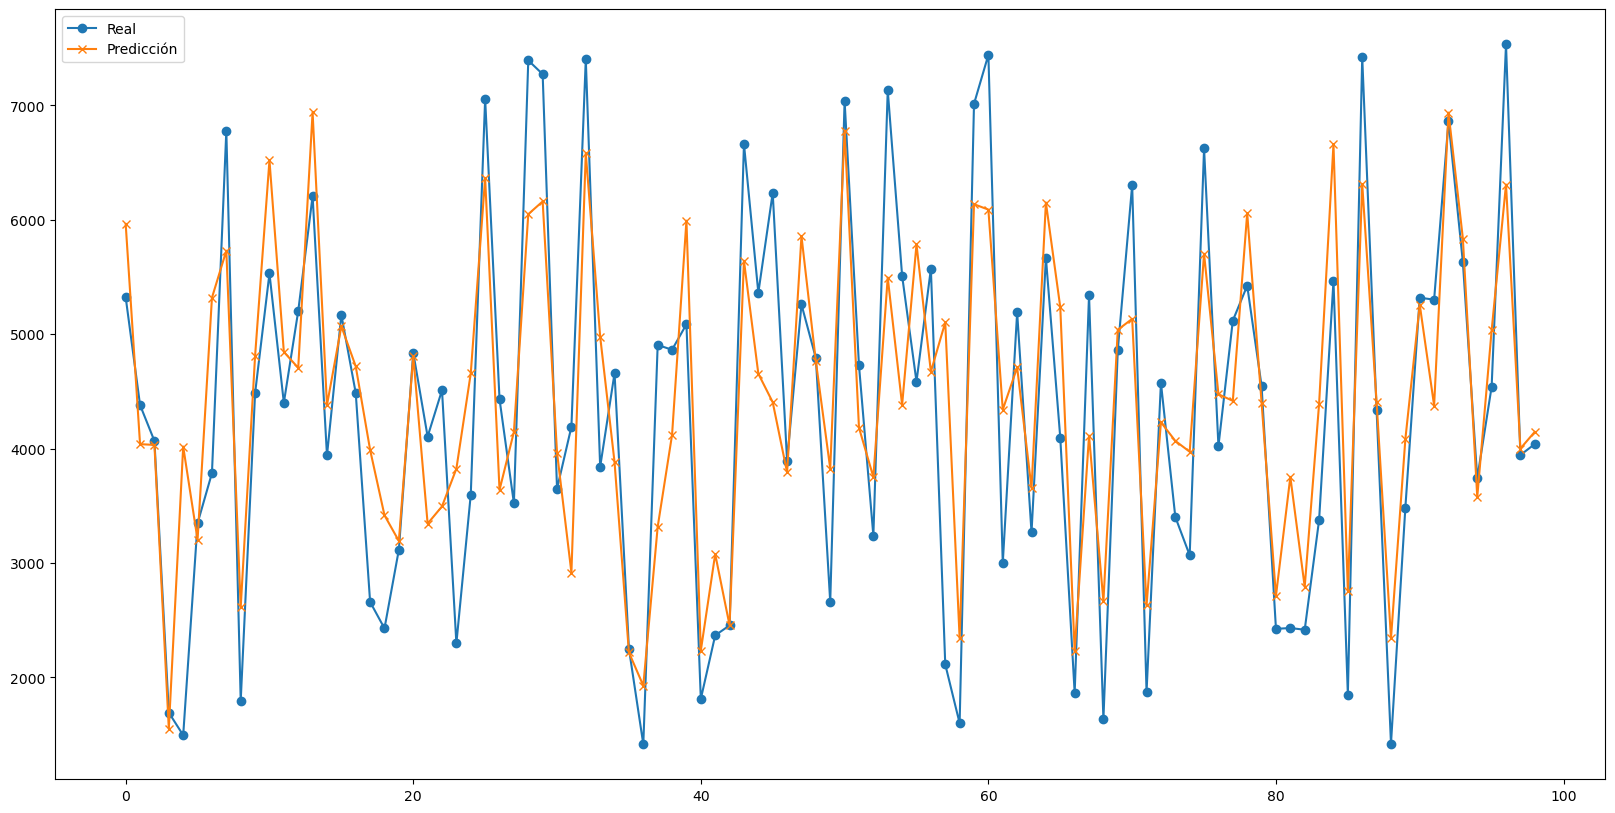

In [1414]:
plt.figure(figsize=(20, 10))
plt.plot(df.index, df['Real'], label='Real', marker='o')
plt.plot(df.index, df['Prediccion'], label='Predicción', marker='x')
plt.legend()
plt.show()

<h3 style="text-align: center">Regresión Logística  utilizando  Dataset de alquiler de bicicletas en Washington</h3>

Convertimos la media en una clasificación binaria para poder aplicar regresión logística. 
  
   * Calculamos la media de las etiquetas de entrenamiento *y_train*, la cual nos sirve para decidir que predicción será considerada **alta (>media)** y cuál **baja (<= media)**.
   * Binarizamos las etiquetas de entrenamiento (*y_train*) y prueba (*y_test*).

In [1415]:
umbral = y_train.mean()
y_train_bin = (y_train > umbral).astype(int).flatten()
y_test_bin = (y_test > umbral).astype(int).flatten()

Clasificamos las etiquetas binarizadas en función de las características de entrada. 
  
   * Creamos una instancia del modelo de regresión logística, lo entrenamos usando los datos de entrenamiento *x_train* y *y_train* y realizamos las predicciones sobre el ocnjunto de prueba *x_test*.


In [1416]:
modelo_logistico = LogisticRegression()

modelo_logistico.fit(X_train, y_train_bin)
y_pred_logistico = modelo_logistico.predict(X_test)
accuracy = accuracy_score(y_test_bin, y_pred_logistico)

print("Precisión:", accuracy)


Precisión: 0.8383838383838383


Hemos comprobado que tenemos mucho mejor resultado sin usar el SGDClassifier, al regularizar tanto con l1,l2 o elasticne o sin usar regularizacion nos empeora la precisión del modelo.

In [1417]:
#hinge
modelo_logistico = SGDClassifier(loss="log_loss", max_iter=16, random_state=42).fit(X_train, y_train_bin)

y_pred_logistico = modelo_logistico.predict(X_test)
accuracy = accuracy_score(y_test_bin, y_pred_logistico)

print("Precisión:", accuracy)

Precisión: 0.8080808080808081


c:\Users\santiago.fernandezse\AppData\Local\miniconda3\envs\pia\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [1418]:
def probar_penalizaciones(X_train, y_train_bin, X_test, y_test_bin):
    penalizaciones = ['l1', 'l2', 'elasticnet']
    resultados = {}

    for penalty in penalizaciones:
        modelo_logistico = SGDClassifier(loss="log_loss", max_iter=50, random_state=42, penalty=penalty).fit(X_train, y_train_bin)
        y_pred_logistico_prueba = modelo_logistico.predict(X_test)
        accuracy = accuracy_score(y_test_bin, y_pred_logistico_prueba)
        resultados[penalty] = accuracy

    for penalty, accuracy in resultados.items():
        print(f"Precisión con penalización {penalty}: {accuracy:.4f}")

# Llamar a la función con tus datos
probar_penalizaciones(X_train, y_train_bin, X_test, y_test_bin)

Precisión con penalización l1: 0.7475
Precisión con penalización l2: 0.6768
Precisión con penalización elasticnet: 0.8182


c:\Users\santiago.fernandezse\AppData\Local\miniconda3\envs\pia\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


   * Evaluamos el modelo de regresión calculando la **matriz de confusión**.

   Podemos ver como la precision es de 0.85

In [1419]:
# Evaluar Regresión Logística
conf_matrix = confusion_matrix(y_test_bin, y_pred_logistico)
accuracy = accuracy_score(y_test_bin, y_pred_logistico)
class_report = classification_report(y_test_bin, y_pred_logistico)


In [1420]:
print("Precisión:", accuracy)
print("Matriz de Confusión:\n", conf_matrix)
print("Informe de Clasificación:\n", class_report)

Precisión: 0.8080808080808081
Matriz de Confusión:
 [[43 11]
 [ 8 37]]
Informe de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82        54
           1       0.77      0.82      0.80        45

    accuracy                           0.81        99
   macro avg       0.81      0.81      0.81        99
weighted avg       0.81      0.81      0.81        99



Creamos un DataFrame para visualizar las variables de prueba y su comparación con la de precicción o valor real.

In [1421]:
df = pd.DataFrame({
    'mnth': X_test[:, 0].flatten(),
    'holiday': X_test[:, 1].flatten(),
    'yr': X_test[:, 2].flatten(),
    'weekday': X_test[:, 3].flatten(),
    'workingday': X_test[:, 4].flatten(),
    'weathersit': X_test[:, 5].flatten(),
    'temp': X_test[:, 6].flatten(),
    'hum': X_test[:, 7].flatten(),
    'windspeed': X_test[:, 8].flatten(),
    'Real': y_test_bin.flatten(),
    'Prediccion': y_pred_logistico.flatten()
})
df

,mnth,holiday,yr,weekday,workingday,weathersit,temp,hum,windspeed,Real,Prediccion
0,11.0,0.0,1.0,4.0,1.0,1.0,0.298422,0.555652,0.115522,1,1
1,10.0,0.0,0.0,0.0,0.0,1.0,0.422333,0.741250,0.099513,0,0
2,11.0,0.0,0.0,6.0,0.0,1.0,0.357942,0.552917,0.212062,0,0
3,3.0,0.0,0.0,0.0,0.0,2.0,0.250339,0.493913,0.184300,0,0
4,11.0,1.0,0.0,4.0,0.0,1.0,0.372471,0.549167,0.167304,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94,12.0,0.0,0.0,3.0,1.0,2.0,0.338362,0.663750,0.060958,0,0
95,7.0,0.0,0.0,2.0,1.0,1.0,0.747479,0.650417,0.130600,0,1
96,10.0,0.0,1.0,2.0,1.0,1.0,0.460846,0.558333,0.182221,1,1
97,4.0,0.0,0.0,3.0,1.0,1.0,0.564392,0.614167,0.241925,0,0


Generamos una gráfica para visualizar los valores reales y las predicciones de nuestro modelo y percibir el margen de error.

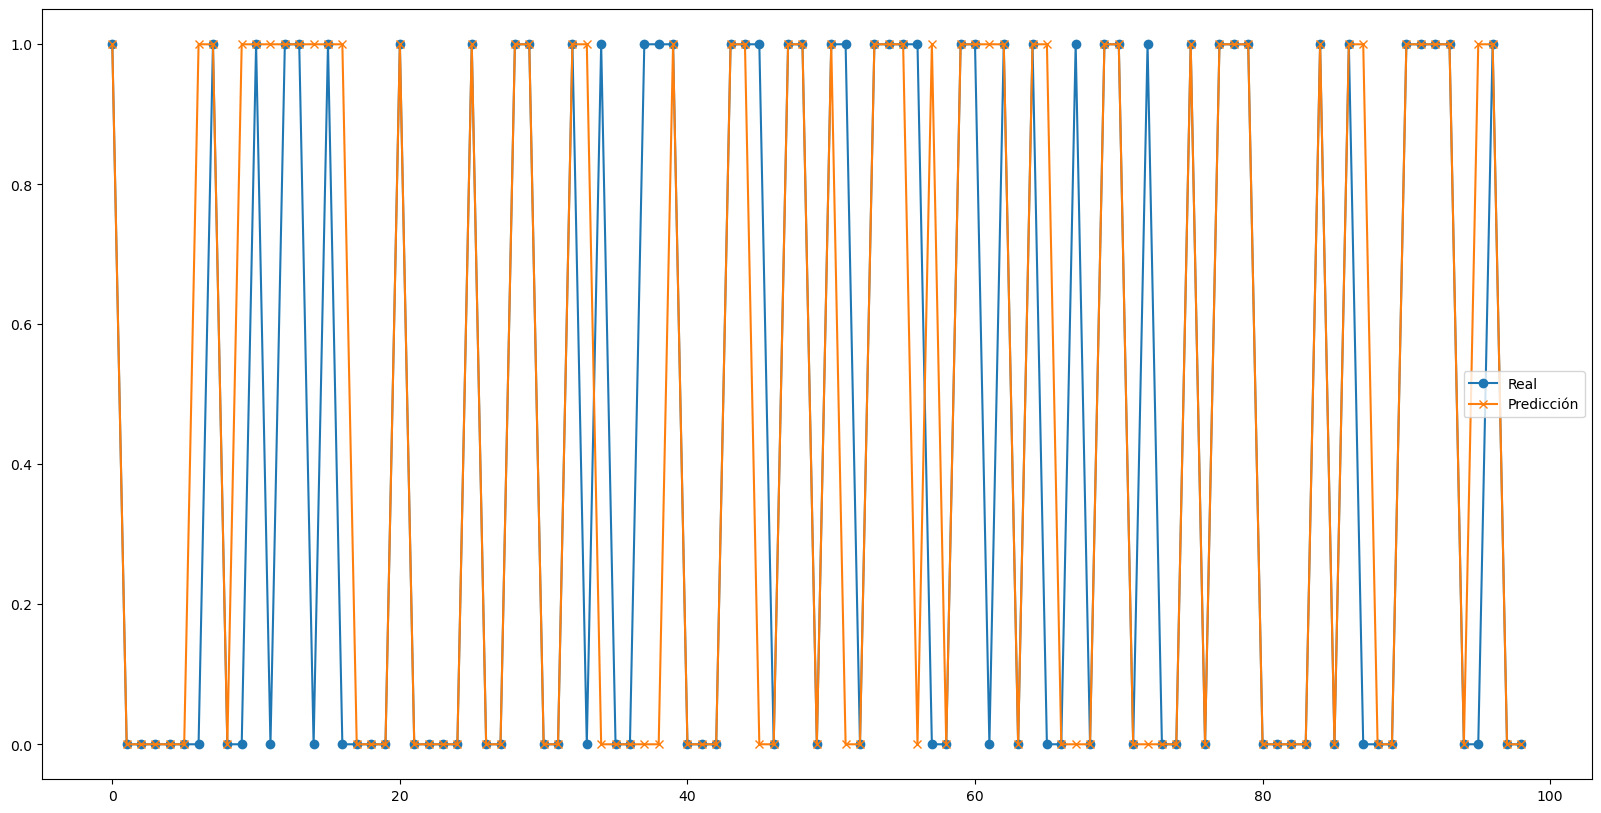

In [1422]:
plt.figure(figsize=(20, 10))
plt.plot(df.index, df['Real'], label='Real', marker='o')
plt.plot(df.index, df['Prediccion'], label='Predicción', marker='x')
plt.legend()
plt.show()

Visualizamos la **matriz de confusión** utilizando *Seaborn* y *Matplotlib* para mostrar el resultado de el modelo de *regresión logística* bajo la clasificación de las etiquetas binarizadas "alta demanda" y "baja demanda". 

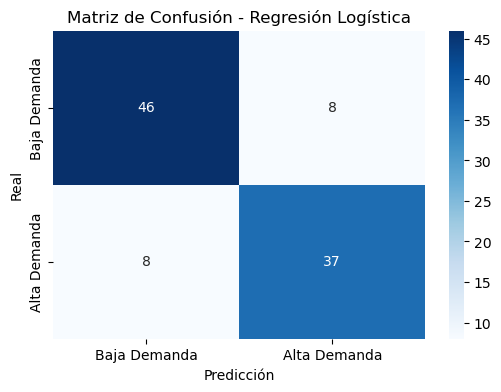

In [1423]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Baja Demanda", "Alta Demanda"], 
            yticklabels=["Baja Demanda", "Alta Demanda"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

Creamos la grafica revisando el AUC (Área bajo la curva)

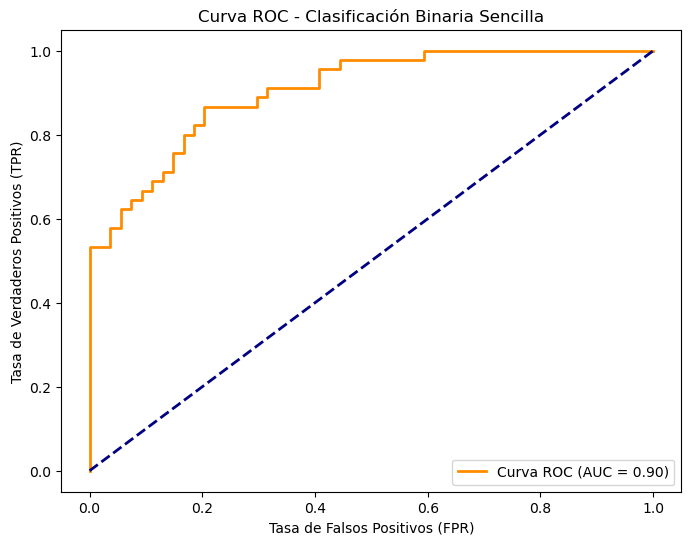

AUC: 0.90


In [1424]:
# Realizar predicciones con el conjunto de prueba (probabilidades) para ROC
y_pred_prob = modelo_logistico.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva (1)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)

# Calcular el AUC (Área Bajo la Curva)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria (AUC = 0.5)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Clasificación Binaria Sencilla')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')